# 2024 Winter Introduction to Deep Learning
### Based on Prof. Oh's Youtube Lecture
https://youtube.com/playlist?list=PLvbUC2Zh5oJvByu9KL82bswYT2IKf0K1M

> Assignment #8


*   Youtube Lecture #32-35
*   Written by Seungeun Lee

## 1. Autoencoder
*     Reference. https://dacon.io/codeshare/4551
*     FashionMNIST dataset

#### (1) Extract latent vectors & Reconstruct image w/ Autoencoder (AE)

In [ ]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

In [ ]:
EPOCH = 10
BATCH_SIZE = 64
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cuda


In [ ]:
trainset = datasets.FashionMNIST(
    root      = './.data/',
    train     = True,
    download  = True,
    transform = transforms.ToTensor()
)
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True,
    num_workers = 2
)

100%|██████████| 26421880/26421880 [00:01<00:00, 13225982.91it/s]


Extracting ./.data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 210066.08it/s]


Extracting ./.data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3899927.96it/s]


Extracting ./.data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6403403.62it/s]

Extracting ./.data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



In [ ]:
# Autoencoder 모듈 정의
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder (input: 28*28 image -> 3 as a latent vector)
        self.encoder = nn.Sequential(#입력받은 이미지를 latent vector를 생성하는 encoder
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3),
        )
        # Decoder (from latent vector (size: 3) -> decode it to 28*28 size image)
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [ ]:
autoencoder = Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.005)
criterion = nn.MSELoss()#MSE 사용

In [ ]:
view_data = trainset.data[:5].view(-1, 28*28) # 복원ㅇ이 어떻게 되는지 확인용
view_data = view_data.type(torch.FloatTensor)/255.

In [ ]:
def train(autoencoder, train_loader):# 학습코드
    autoencoder.train()# 학습용 전환
    for step, (x, label) in enumerate(train_loader):
        x = x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE)#x(입력)와 y(대상 레이블)모두 원본이미지(x)
        label = label.to(DEVICE)

        encoded, decoded = autoencoder(x)

        loss = criterion(decoded, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

[Epoch 1]


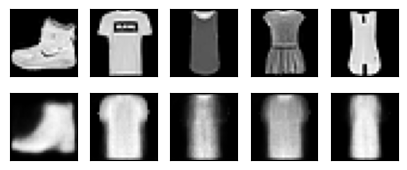

[Epoch 2]


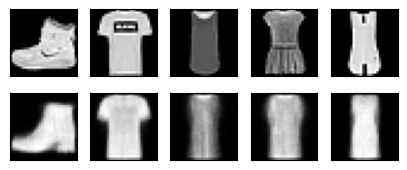

[Epoch 3]


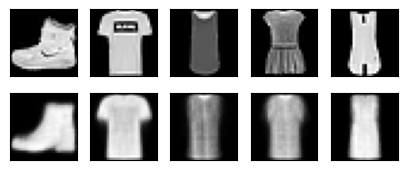

[Epoch 4]


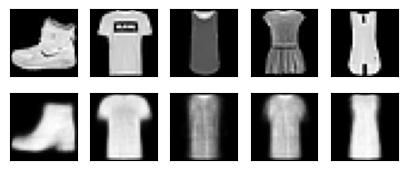

[Epoch 5]


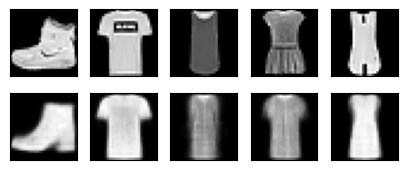

[Epoch 6]


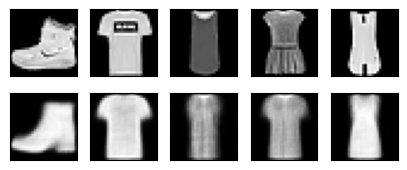

[Epoch 7]


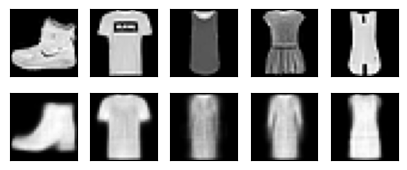

[Epoch 8]


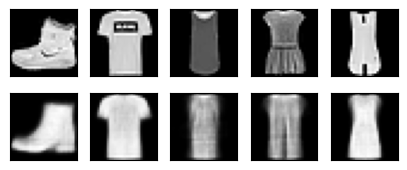

[Epoch 9]


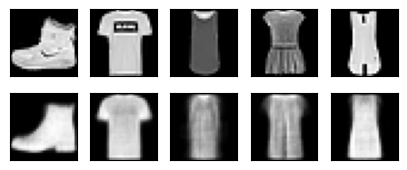

[Epoch 10]


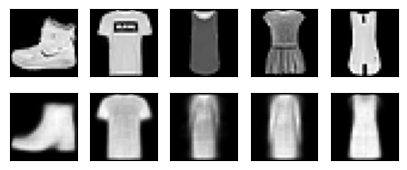

In [ ]:
for epoch in range(1, EPOCH+1):
    train(autoencoder, train_loader)

    test_x = view_data.to(DEVICE)
    _, decoded_data = autoencoder(test_x)

    #원본과 디코딩 결과
    f, a = plt.subplots(2, 5, figsize=(5, 2))
    print("[Epoch {}]".format(epoch))
    for i in range(5):
        img = np.reshape(view_data.data.numpy()[i],(28, 28))
        a[0][i].imshow(img, cmap='gray')
        a[0][i].set_xticks(()); a[0][i].set_yticks(())

    for i in range(5):
        img = np.reshape(decoded_data.to("cpu").data.numpy()[i], (28, 28))
        a[1][i].imshow(img, cmap='gray')
        a[1][i].set_xticks(()); a[1][i].set_yticks(())
    plt.show()

#### (2) Image Denoising w/ AE

In [ ]:
def add_noise(img):# 이미지에 잡음 추가
    noise = torch.randn(img.size()) * 0.2
    noisy_img = img + noise
    return noisy_img

In [ ]:
def train(autoencoder, train_loader):
    autoencoder.train()
    avg_loss = 0
    for step, (x, label) in enumerate(train_loader):
        noisy_x = add_noise(x)
        noisy_x = noisy_x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE)

        label = label.to(DEVICE)
        encoded, decoded = autoencoder(noisy_x)

        loss = criterion(decoded, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss.item() # 오차 관찰
    return avg_loss / len(train_loader)

In [ ]:
for epoch in range(1, EPOCH+1):
    loss = train(autoencoder, train_loader)
    print("[Epoch {}] loss:{}".format(epoch, loss))

[Epoch 1] loss:0.023030459485662135
[Epoch 2] loss:0.022597718529149033
[Epoch 3] loss:0.022573403078816466
[Epoch 4] loss:0.022420519081228323
[Epoch 5] loss:0.022469314756487477
[Epoch 6] loss:0.02226978555710903
[Epoch 7] loss:0.022355424273989476
[Epoch 8] loss:0.02239925503285963
[Epoch 9] loss:0.022393325875912393
[Epoch 10] loss:0.022247172981452967


In [ ]:
testset = datasets.FashionMNIST(
    root      = './.data/',
    train     = False, # Unseen test dataset
    download  = True,
    transform = transforms.ToTensor()
)
 # 한장 가지고 옴
sample_data = testset.data[0].view(-1, 28*28) # 1차원 행렬 변환
sample_data = sample_data.type(torch.FloatTensor)/255.

original_x = sample_data[0]
noisy_x = add_noise(original_x).to(DEVICE)
_, recovered_x = autoencoder(noisy_x)

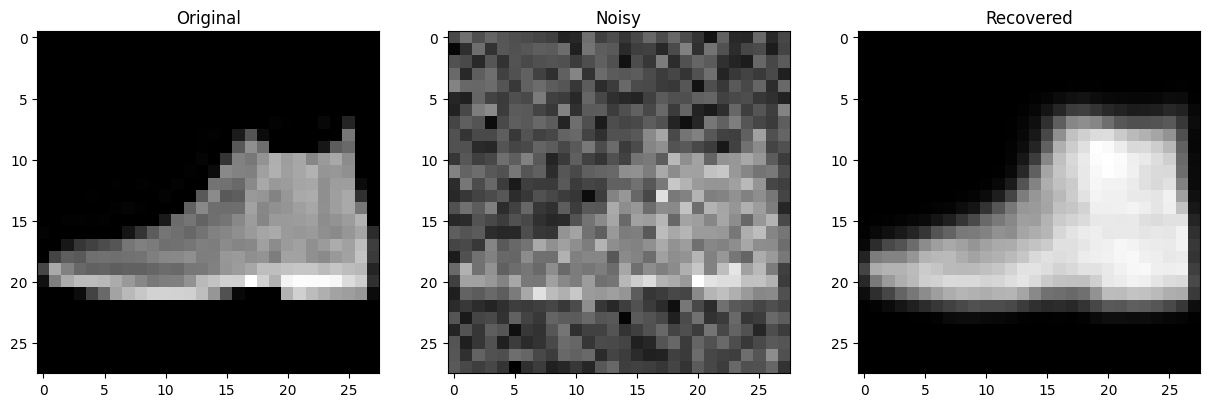

In [ ]:
f, a = plt.subplots(1, 3, figsize=(15, 15))

original_img = np.reshape(original_x.to("cpu").data.numpy(), (28, 28))
noisy_img = np.reshape(noisy_x.to("cpu").data.numpy(), (28, 28))
recovered_img = np.reshape(recovered_x.to("cpu").data.numpy(), (28, 28))

# original image
a[0].set_title('Original')
a[0].imshow(original_img, cmap='gray')

# original image w/ noise
a[1].set_title('Noisy')
a[1].imshow(noisy_img, cmap='gray')

# recoveredimage
a[2].set_title('Recovered')
a[2].imshow(recovered_img, cmap='gray')

plt.show()

### Question 1. Explain the code of the '1. Autoencoder' section "briefly".

## 2. Principal Component Analysis [PCA]
*    Reference. https://romg2.github.io/mlguide/12_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-%EC%99%84%EB%B2%BD%EA%B0%80%EC%9D%B4%EB%93%9C-06.-%EC%B0%A8%EC%9B%90%EC%B6%95%EC%86%8C-PCA/



#### Question 2. What is PCA in "mathematical" perspective? Google it and write your own answer.

PCA는 분산이 최대화되는 방향으로 데이터를 줄암으로써 데이터의 주요 패턴을 캡쳐하며 차원을 줄이는 것, 데이터의 중요한 정보를 최대한 보존하는 것

## **차원 축소 장점**

계산 효율성 증가

데이터 시각화

노이즈 제거

과적합 방지


In [ ]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

mpl.rc('font', family='NanumGothic')
mpl.rc('axes', unicode_minus=False)

sns.set(font="NanumGothic", rc={"axes.unicode_minus":False}, style='darkgrid')
plt.rc("figure", figsize=(10,8))

warnings.filterwarnings("ignore")

In [ ]:
from sklearn.datasets import load_iris

iris = load_iris()

columns = ['sepal_length','sepal_width','petal_length','petal_width']
iris_df = pd.DataFrame(data = iris.data, columns = columns)
iris_df["target"] = iris.target

iris_df.head()

,sepal_length,sepal_width,petal_length,petal_width,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


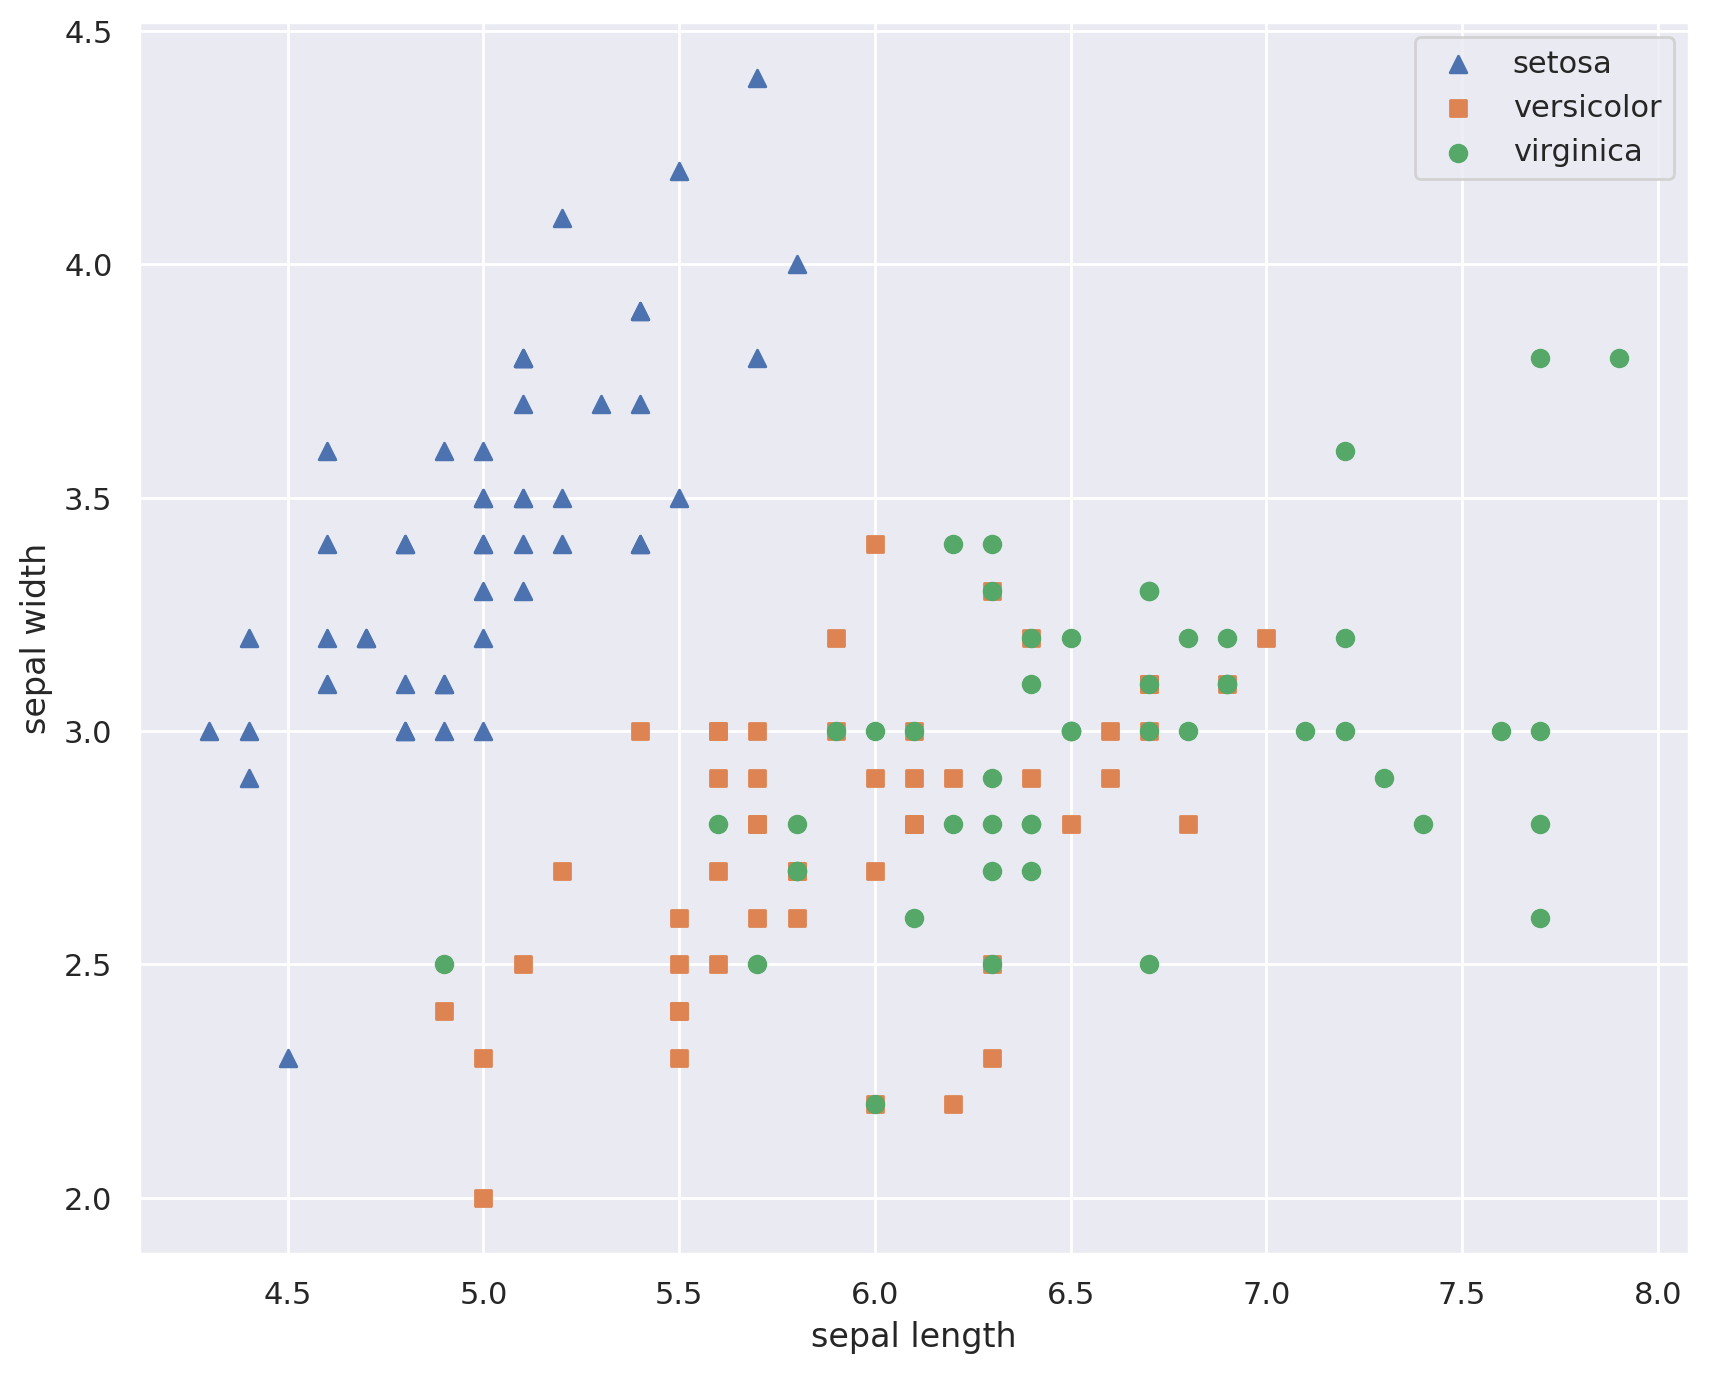

In [ ]:
markers = ["^", "s", "o"]

# 0:setosa, 1:versicolor, 2:virginica
for i, marker in enumerate(markers):
    x_axis_data = iris_df[iris_df['target']==i]['sepal_length']
    y_axis_data = iris_df[iris_df['target']==i]['sepal_width']
    plt.scatter(x_axis_data, y_axis_data, marker=marker, label=iris.target_names[i])

plt.legend()
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

iris_f_scaled = StandardScaler().fit_transform(iris_df.iloc[:,:-1])

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2) # of principal components = 2

pca.fit(iris_f_scaled)
iris_pca = pca.transform(iris_f_scaled)

print(f"scaled: {iris_f_scaled.shape}")
print(f"pca: {iris_pca.shape}")

scaled: (150, 4)
pca: (150, 2)


In [ ]:
pca_columns=['pca_component_1','pca_component_2']

iris_df_pca = pd.DataFrame(iris_pca, columns = pca_columns)
iris_df_pca['target'] = iris.target

iris_df_pca.head(3)

,pca_component_1,pca_component_2,target
0,-2.264703,0.480027,0
1,-2.080961,-0.674134,0
2,-2.364229,-0.341908,0


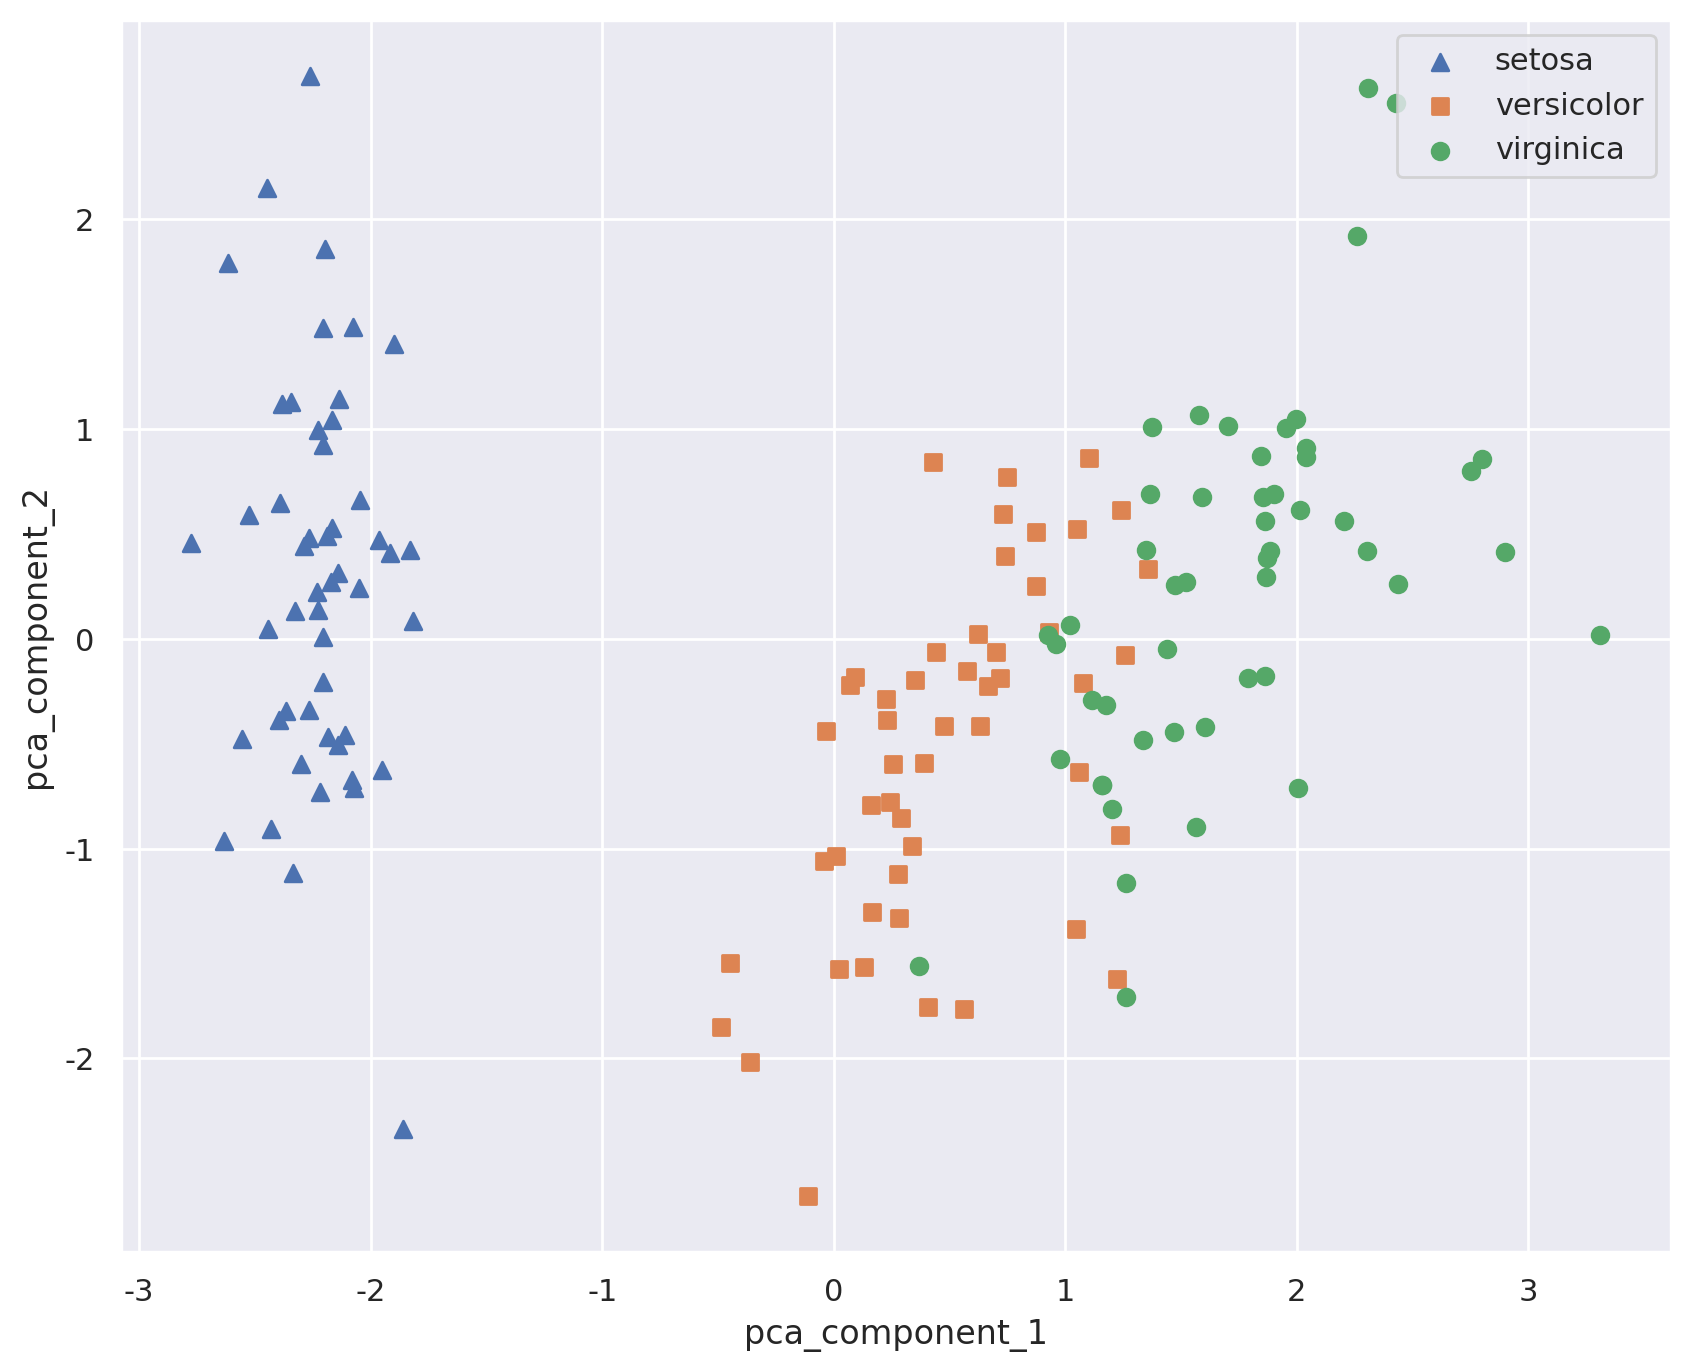

In [ ]:
markers = ["^", "s", "o"]

# 0:setosa, 1:versicolor, 2:virginica
for i, marker in enumerate(markers):
    x_axis_data = iris_df_pca[iris_df_pca['target']==i]['pca_component_1']
    y_axis_data = iris_df_pca[iris_df_pca['target']==i]['pca_component_2']
    plt.scatter(x_axis_data, y_axis_data, marker=marker,label=iris.target_names[i])

plt.legend()
plt.xlabel('pca_component_1')
plt.ylabel('pca_component_2')
plt.show()

In [ ]:
print(pca.explained_variance_ratio_) ## Although we implemented PCA, we can still explain majority of the data

[0.72962445 0.22850762]


### Question 3.
### Autoencoder reduces the dimension of the data w/ deep learning methods.
### PCA does the same thing in mathematically linear way.
### In this context, Autoencoder is a _ _ _ _ _ _ _ _ _ PCA.
### Hint: n _ _ l _ _ _ _ _

In [ ]:
# non linear

## 3. Variational Autoencoder (VAE)







### Question 4 (Optional).
### Read the following document, run the whole code and write an explanation.
### https://github.com/Jackson-Kang/Pytorch-VAE-tutorial/blob/master/01_Variational_AutoEncoder.ipynb

## 4. Seq2Seq, Attention, Transformer

### Question 4 (Optional).
### Choose one of the following document. Read it, run the whole code and write and explanation.
### (1) Machine Translation using Attention and Seq2Seq: https://tutorials.pytorch.kr/intermediate/seq2seq_translation_tutorial.html
### (2) Understanding Transformer: https://wikidocs.net/156986
### (3) Chatbot based on Text Similarity (Transformer): https://wikidocs.net/157970

In [ ]:
# 어려워서 제가 따로 차근차근 해볼께요

### The End.

##### Please upload your Colab file @Github https://github.com/duneag2/intro-dl/tree/main/Assignment8

*   First, make your folder by your name (e.g. seungeun)
*   Then upload your "Jupyter Notebook" file under that directory

###### Need Help?



*   Please refer to this link https://yeko90.tistory.com/entry/%ED%8C%8C%EC%9D%B4%EC%8D%AC-colab%EC%BD%94%EB%9E%A9%EC%97%90%EC%84%9C-%EC%95%95%EC%B6%95%ED%8C%8C%EC%9D%BC-%ED%92%80%EA%B8%B0 OR
*   Just save your Jupyter Notebook (.ipynb) file in here (colab) and upload via 'Add file' - 'Upload files' https://nthree.tistory.com/60